### Deep Chemometrics with Data Augmentation, here implemented in fastai V1

This is an example of how to build a simple convolutional neural network (CNN) to build predictive models from spectroscopic data. The dataset consists of NIR transmission measurements of pharmaceutical tablets from two separate instruments of the same brand and type together with information about content of the active ingredients measured in the laboratory. A predictive regression model is built and tested with the fastai V1 Python library utilising PyTorch. <br> <br> The background and concept is further described in the original publication preprint which can be downloaded from https://arxiv.org/pdf/1710.01927.pdf and also featuring in the blog post: https://www.wildcardconsulting.dk/useful-information/deep-chemometrics-deep-learning-for-spectroscopy/


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
import fastai.vision
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset
The dataset was downloaded from http://www.eigenvector.com/data/tablets/index.html and  placed in the Dataset folder. It is a MATLAB format file that can be loaded into Python but using the scipy.io module.

In [3]:
import scipy.io as sio

def get_xY(filename, maxx=600):
    
    sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = matcontents.keys()
#    for key in list(keys):
#        if key[0] == '_':
#            keys.remove(key)
#            print('_', key)
            
            
    d = {}            
    for key in keys:
        if key[0] != '_':
            data = matcontents[key][0][0]
            if key[-1] == "Y":
                Ydata = data[5]
                d[key] = Ydata
            else:
                xdata = data[5][:,:maxx]
                d[key] = xdata
                d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

The data set contains measurements on the same tablets from two spectrometers, and are already divided into calibration, validation and test sets

In [4]:
filename = 'Dataset/nir_shootout_2002.mat'
print('Names of all data sets in the matlab file')
print(sio.whosmat(filename))

Names of all data sets in the matlab file
[('calibrate_1', (1, 1), 'object'), ('calibrate_2', (1, 1), 'object'), ('test_1', (1, 1), 'object'), ('test_2', (1, 1), 'object'), ('validate_1', (1, 1), 'object'), ('validate_2', (1, 1), 'object'), ('calibrate_Y', (1, 1), 'object'), ('test_Y', (1, 1), 'object'), ('validate_Y', (1, 1), 'object')]


In [5]:
# Load the data into the Python dictionary "dataset"
dataset = get_xY(filename)
print('The names of all datasets present in the Python dictionary "dataset"')
print(dataset.keys())

The names of all datasets present in the Python dictionary "dataset"
dict_keys(['calibrate_1', 'axisscale', 'calibrate_2', 'test_1', 'test_2', 'validate_1', 'validate_2', 'calibrate_Y', 'test_Y', 'validate_Y'])


### Using matplotlib, the spectra can be plotted

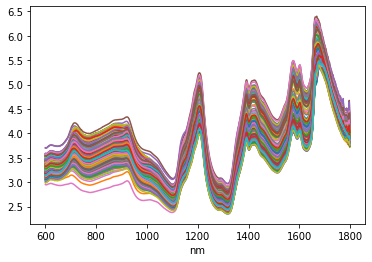

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dataset['axisscale'],dataset['test_1'].T)
_ = plt.xlabel('nm')

Neural networks like the input and output to be near the -1 to 1 range, so the an instantiated object of the GlobalStandardScaler class will be used to scale spectral data to unit mean and 1/2.5 standard deviation. It works on a global scale, not per feature as is otherwise the norm for scikit-learn scalers.

The relative differences between spectra are not changed, but the range is adjusted and the mean moved to zero. Below, we also scale the measured API concentration with another instance of GlobalScaler (Here scikit learns standard scaler would also have worked)

In [7]:
def print_stat(tbl, inpName):
    print()
    print(inpName)
    print( '    shape', tbl.shape )
    print( '    std()', tbl.std() )
    print( '    min()', tbl.min() )
    print( '    mean()', tbl.mean() )
    print( '    max()', tbl.max() )

In [8]:
print_stat(dataset['test_1'], "dataset['test_1']")
print_stat(dataset['calibrate_2'], "dataset['calibrate_2']")
print_stat(dataset['test_Y'][:,2], "dataset['test_Y'][:,2]")
print_stat(dataset['calibrate_Y'][:,2], "dataset['calibrate_Y'][:,2]")


dataset['test_1']
    shape (460, 600)
    std() 0.6781611319771951
    min() 2.349738
    mean() 3.6771044406449276
    max() 6.401008

dataset['calibrate_2']
    shape (155, 600)
    std() 0.6966018799481806
    min() 2.333711
    mean() 3.694758041010753
    max() 6.069101

dataset['test_Y'][:,2]
    shape (460,)
    std() 15.745496507357688
    min() 154.3000030517578
    mean() 188.3995653235394
    max() 237.6999969482422

dataset['calibrate_Y'][:,2]
    shape (155,)
    std() 21.909316720166
    min() 151.60000610351562
    mean() 192.88516156596523
    max() 239.10000610351562


In [9]:
#Rescale to NN friendly number range
from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

#Calibrate is smaller than test, so they are swapped
X_train = xscaler.fit_transform(dataset['test_1']) #From instrument 1
X_test = xscaler.transform(dataset['calibrate_2']) #! NB only transform on test set. From instrument 2

yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform(dataset['test_Y'][:,2])
y_test = yscaler.transform(dataset['calibrate_Y'][:,2])

X_indepTest0 = np.asarray(xscaler.transform(dataset['test_2']), dtype=np.float32)
X_indepTest = X_indepTest0[:, np.newaxis, :] #Added dim to fit fastai.vision image structure
y_indepTest = y_train


print_stat(X_train, 'X_train')
print_stat(y_train, 'y_train')
print_stat(X_test, 'X_test')
print_stat(y_test, 'y_test')



X_train
    shape (460, 600)
    std() 1.0000000000000002
    min() -1.9573024434104016
    mean() -4.6133789220365925e-17
    max() 4.016602295406501

y_train
    shape (460,)
    std() 1.0
    min() -2.165670816150336
    mean() -2.0852884636437723e-16
    max() 3.131081423927487

X_test
    shape (155, 600)
    std() 1.0271922808628402
    min() -1.9809354699055541
    mean() 0.0260315720459467
    max() 3.5271802622794803

y_test
    shape (155,)
    std() 1.3914655984286064
    min() -2.337148225387988
    mean() 0.2848812192317815
    max() 3.2199963180763778


# Data Augmentation
Instead of correction of the baseline variations we use a special implementation of data augmentation. The idea is to simulate the expected form of irrelevant noise (here baseline offset and slope and overall spectrum intensity), and expect the neural network to either extract features robust to the variations, or figure out the best corrections during training. In this way we can make more efficient use of the labelled dataset. The idea is similar to the image rotations and croppings done in image recognition training.

In [10]:
#Expand dataset, Function also available in ChemUtils
def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

In [11]:
shift = np.std(X_train)*0.1
print('shift',shift)

X_train_aug = np.repeat(X_train, repeats=100, axis=0)
X_train_aug = dataaugment(X_train_aug, betashift = shift, slopeshift = 0.05, multishift = shift)

y_train_aug = np.repeat(y_train, repeats=100, axis=0) #y_train is simply repeated


print( len(X_train_aug), X_train_aug.shape)
print( len(y_train_aug),  y_train_aug.shape)
#_ = plt.plot(X_train_aug[0:100].T)

shift 0.10000000000000003
46000 (46000, 600)
46000 (46000,)


### Check sizes  and types of data

In [12]:
#X_train_aug = X_train_aug[:, np.newaxis, :]
print('X_train_aug', X_train_aug.shape)
print('y_train_aug', y_train_aug.shape)
print('y_train_aug', type(y_train_aug[0]))
print()

X_train_aug (46000, 600)
y_train_aug (46000,)
y_train_aug <class 'numpy.float64'>



### Concatenate the training and the validation sets
Concatenate the training set from instrument 1 and the validation set from the instrument 2 <br><br>
-- and add a dimension to fit the fastai structure for images as the second index for the X training data. It should be 3 for color images and 1 for black and white images. Whe have only one channel so we need to set a 1 here (see line 2 below) 

In [13]:
X_train_valid0 = np.vstack((X_train_aug, X_test))
X_train_valid = X_train_valid0[:, np.newaxis, :] #Added dim to fit fastai.vision image structure
X_train_valid0 = np.vstack((X_train_aug, X_test))
y_train_valid = np.hstack((y_train_aug, y_test))
print('X_train_valid', X_train_valid.shape)
print('y_train_valid', y_train_valid.shape)

X_train_valid (46155, 1, 600)
y_train_valid (46155,)


In [14]:
class ArrayImageList(fastai.vision.ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)),inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],
                                     label_cls=label_cls,
                                     **kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = fastai.vision.torch.tensor(n).float()
        return fastai.vision.Image(n)

### The split function is dealing with the validation set
We use split_by_idx here as we need to point directly to the concatenated the validation data. Another way in other cases may be to use split_subsets where validation data is taken randomly from the traing set. This is inserted as a commented out alternative example.

In [15]:
data2 = (ArrayImageList.from_numpy(X_train_valid)
#        .split_subsets(train_size=0.8, valid_size=0.2)
        .split_by_idx(valid_idx=range(46000,46155)) 
        .label_from_array(y_train_valid)
        .databunch(bs=100))

In [16]:
dataIndep = (ArrayImageList.from_numpy(X_indepTest)
             .split_none()
             .label_from_array(y_indepTest)
             .databunch())

In [17]:
dataIndep

ImageDataBunch;

Train: LabelList (460 items)
x: ArrayImageList
Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600)
y: FloatList
0.33028117,0.36838672,0.49540716,0.5589174,1.3019868
Path: .;

Valid: LabelList (0 items)
x: ArrayImageList

y: FloatList

Path: .;

Test: None

In [18]:
data2


ImageDataBunch;

Train: LabelList (46000 items)
x: ArrayImageList
Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600)
y: FloatList
0.33028117,0.33028117,0.33028117,0.33028117,0.33028117
Path: .;

Valid: LabelList (155 items)
x: ArrayImageList
Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600),Image (1, 600)
y: FloatList
0.7430976,0.65418273,0.8256601,0.7303948,0.69228923
Path: .;

Test: None

## Build the fastai CNN layers
Models with multiple (more than one) non-linear layers counts as deep learning models by some. Here we have two 😊

In [19]:
def conv(ni,nf): 
    return fastai.vision.nn.Conv1d(ni, nf, 
                                   kernel_size=31, 
                                   padding=31//2)

# Kernel is an odd positive number; 
# padding is floor(kernel size / 2) 

In [20]:
model = fastai.vision.nn.Sequential(
    conv(1, 8),
    fastai.vision.nn.BatchNorm1d(8),
    fastai.vision.nn.ReLU(),
    conv(8, 16),
    fastai.vision.nn.BatchNorm1d(16),
    fastai.vision.nn.ReLU(),
    fastai.vision.Flatten(),
    fastai.vision.nn.Dropout(),
    fastai.vision.nn.Linear(9600,128), 
    fastai.vision.nn.Linear(128,1)     
    )

### Way to restart the model building
Commented out

In [21]:

# learn.destroy()
# Alterntative:
# del learn
# fastai.vision.gc.collect()

### Build the "learn" object that keeps the data structure, and definition of the model 

In [22]:
learn = fastai.vision.Learner(data2, model, metrics=fastai.vision.mse)

### Get a summary of the model structure

In [23]:
learn.summary()


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               [8, 600]             256        True      
______________________________________________________________________
BatchNorm1d          [8, 600]             16         True      
______________________________________________________________________
ReLU                 [8, 600]             0          False     
______________________________________________________________________
Conv1d               [16, 600]            3,984      True      
______________________________________________________________________
BatchNorm1d          [16, 600]            32         True      
______________________________________________________________________
ReLU                 [16, 600]            0          False     
______________________________________________________________________
Flatten              [9600]               0          False     
___________________________________________________

In [24]:
# Kept as a note, of what did not work in this case
# learn = fastai.vision.Learner(data2, model, loss_func = mod_MSELoss(), metrics=fastai.vision.mse)
# Do not give a loss function
# This took care of the loss func input [100,1] vs target [100] mismatch

### Run the learning rate finder

epoch,train_loss,valid_loss,mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


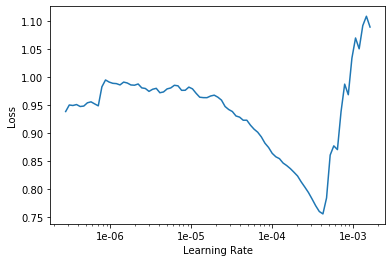

In [25]:
learn.lr_find(end_lr=3e-3)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(1, max_lr=2e-4)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.100386,0.097327,0.097327,00:01


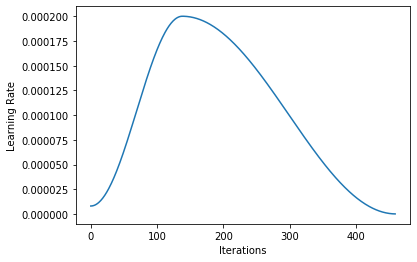

In [27]:
learn.recorder.plot_lr()

epoch,train_loss,valid_loss,mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


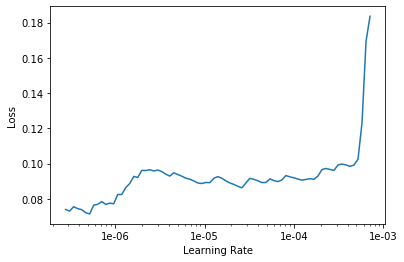

In [28]:
learn.lr_find(end_lr=3e-3)
learn.recorder.plot()

##### Run 5 epochs of model training at set learning rate

In [29]:
learn.fit_one_cycle(5, max_lr=4e-7)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.099499,0.097659,0.097659,00:01
1,0.094550,0.098077,0.098077,00:01
2,0.100438,0.097988,0.097988,00:01
3,0.091022,0.100065,0.100065,00:01
4,0.097652,0.099176,0.099176,00:01


### Get and plot prediction data for the validation set

In [30]:
preds, y, losses = learn.get_preds(with_loss=True)

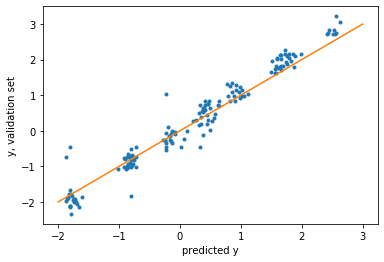

In [31]:
plt.plot(np.asarray(preds), np.asarray(y), '.')
plt.plot([-2,3], [-2,3])
plt.ylabel('y, validation set')
_  = plt.xlabel('predicted y')

### Re-run the learning rate finder, to see current status

epoch,train_loss,valid_loss,mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


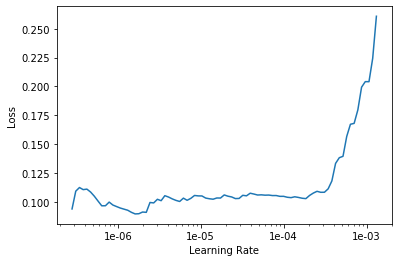

In [32]:
learn.lr_find(end_lr=3e-3)
learn.recorder.plot()

### Run some epochs with low learning rate, to get some improvements?

In [33]:
learn.fit_one_cycle(5, max_lr=4e-6)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.092408,0.095258,0.095258,00:01
1,0.097013,0.105439,0.105439,00:01
2,0.089613,0.092011,0.092011,00:01
3,0.081903,0.095705,0.095705,00:01
4,0.084004,0.093956,0.093956,00:01


### Plot prediction results again

n= torch.Size([155, 1]) torch.Size([155])


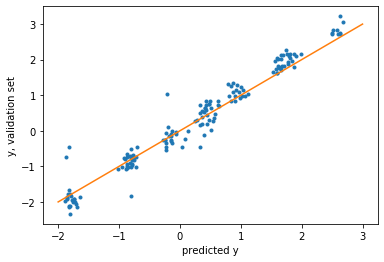

In [34]:
preds, y, losses = learn.get_preds(with_loss=True)
print('n=',preds.shape, y.shape)
plt.plot(np.asarray(preds), np.asarray(y), '.')
plt.plot([-2,3], [-2,3])
plt.ylabel('y, validation set')
_  =plt.xlabel('predicted y')

In [35]:
ypred_indep = learn.predict(X_indepTest[0,:,:])
ypred_indep
type(ypred_indep[0])


fastai.core.FloatItem

In [36]:
print('X_indepTest.shape', X_indepTest.shape)
n_indep = X_indepTest.shape[0]
prd_indep = np.zeros((n_indep))
for prd in range(n_indep):
    ypred_indep = learn.predict(X_indepTest[prd,:,:])
    prd_indep[prd] = float(ypred_indep[1])
    

X_indepTest.shape (460, 1, 600)


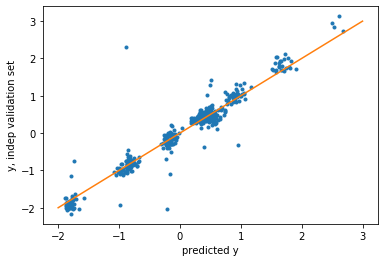

In [37]:
plt.plot(prd_indep, y_indepTest, '.')
plt.plot([-2,3], [-2,3])
plt.ylabel('y, indep validation set')
_  =plt.xlabel('predicted y')

In [38]:
## Try load_learner in next notebook after export

In [39]:
learn.export('NIR_model05.pkl')

### Keras model, for reference
See  https://arxiv.org/pdf/1710.01927.pdf for further details